# DeepSeek-OCR: Contexts Optical Compression on A100

Hands-on notebook for the DeepSeek-OCR paper (https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek_OCR_paper.pdf). Compresses document images to ~100 vision tokens (10-20x fewer than text) and decodes with 97% OCR precision at 10x ratio. Uses DeepEncoder (SAM + CLIP + 16x compressor) + 3B MoE decoder.

**Key Features**:
- Flash Attention for A100 speed (~1-2s/page).
- Multi-res modes (Tiny to Gundam for high-res PDFs).
- Batch PDF to Markdown—scales to 200k pages/day.
- From paper: Beats GOT-OCR2.0 on OmniDocBench with fewer tokens.

**Requirements**: Python 3.12, A100 GPU, ~10GB disk. Run cells sequentially.

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Uninstall conflicts
%uv pip uninstall --system torch torchvision torchaudio flash-attn transformers tokenizers vllm

# Official cu118 install (Torch 2.6.0 + compatible Vision 0.21.0)
%uv pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu118

# Core pkgs
%uv pip install transformers==4.46.3 tokenizers==0.20.3 einops addict easydict accelerate pillow pymupdf

# FlashAttn: Source compile for A100 ABI match (fallback pip if fails)
!git clone https://github.com/Dao-AILab/flash-attention.git
%cd flash-attention
%uv pip install -e . --no-build-isolation MAX_JOBS=4  # ~5 mins on A100
%cd ..

import torch
print(f"Torch: {torch.__version__} | CUDA: {torch.version.cuda} | GPU: {torch.cuda.get_device_name(0)}")

After restart, verify installations. This ensures FlashAttn loads without ABI errors (common on A100).

Expected: "FlashAttn 2.8.2 ready!" If fails, fallback to pip install.

In [ ]:
try:
    import flash_attn
    print(f"FlashAttn {flash_attn.__version__} ready!")
except ImportError:
    # Fallback pip
    !pip install flash-attn==2.7.3 --no-build-isolation
    import flash_attn
    print("FlashAttn via pip—good for A100.")

Load DeepSeek-OCR (~3.4B params: 380M encoder + 3B MoE decoder). Uses Flash Attention for fast global attn in the decoder. BF16 leverages A100's tensor cores.

`trust_remote_code=True` for custom DeepEncoder.

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # A100

model_name = "deepseek-ai/DeepSeek-OCR"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id  # Quiet masks

model = AutoModel.from_pretrained(
    model_name,
    _attn_implementation="flash_attention_2",  # Official: Fast on A100
    trust_remote_code=True,
    use_safetensors=True,
    torch_dtype=torch.bfloat16,  # A100 BF16 native
    device_map="auto"
)

model = model.eval()

Load a single image (JPG/PNG, e.g., scanned doc page). Display for verification. Supports up to 1280x1280 for Large mode (~400 tokens).

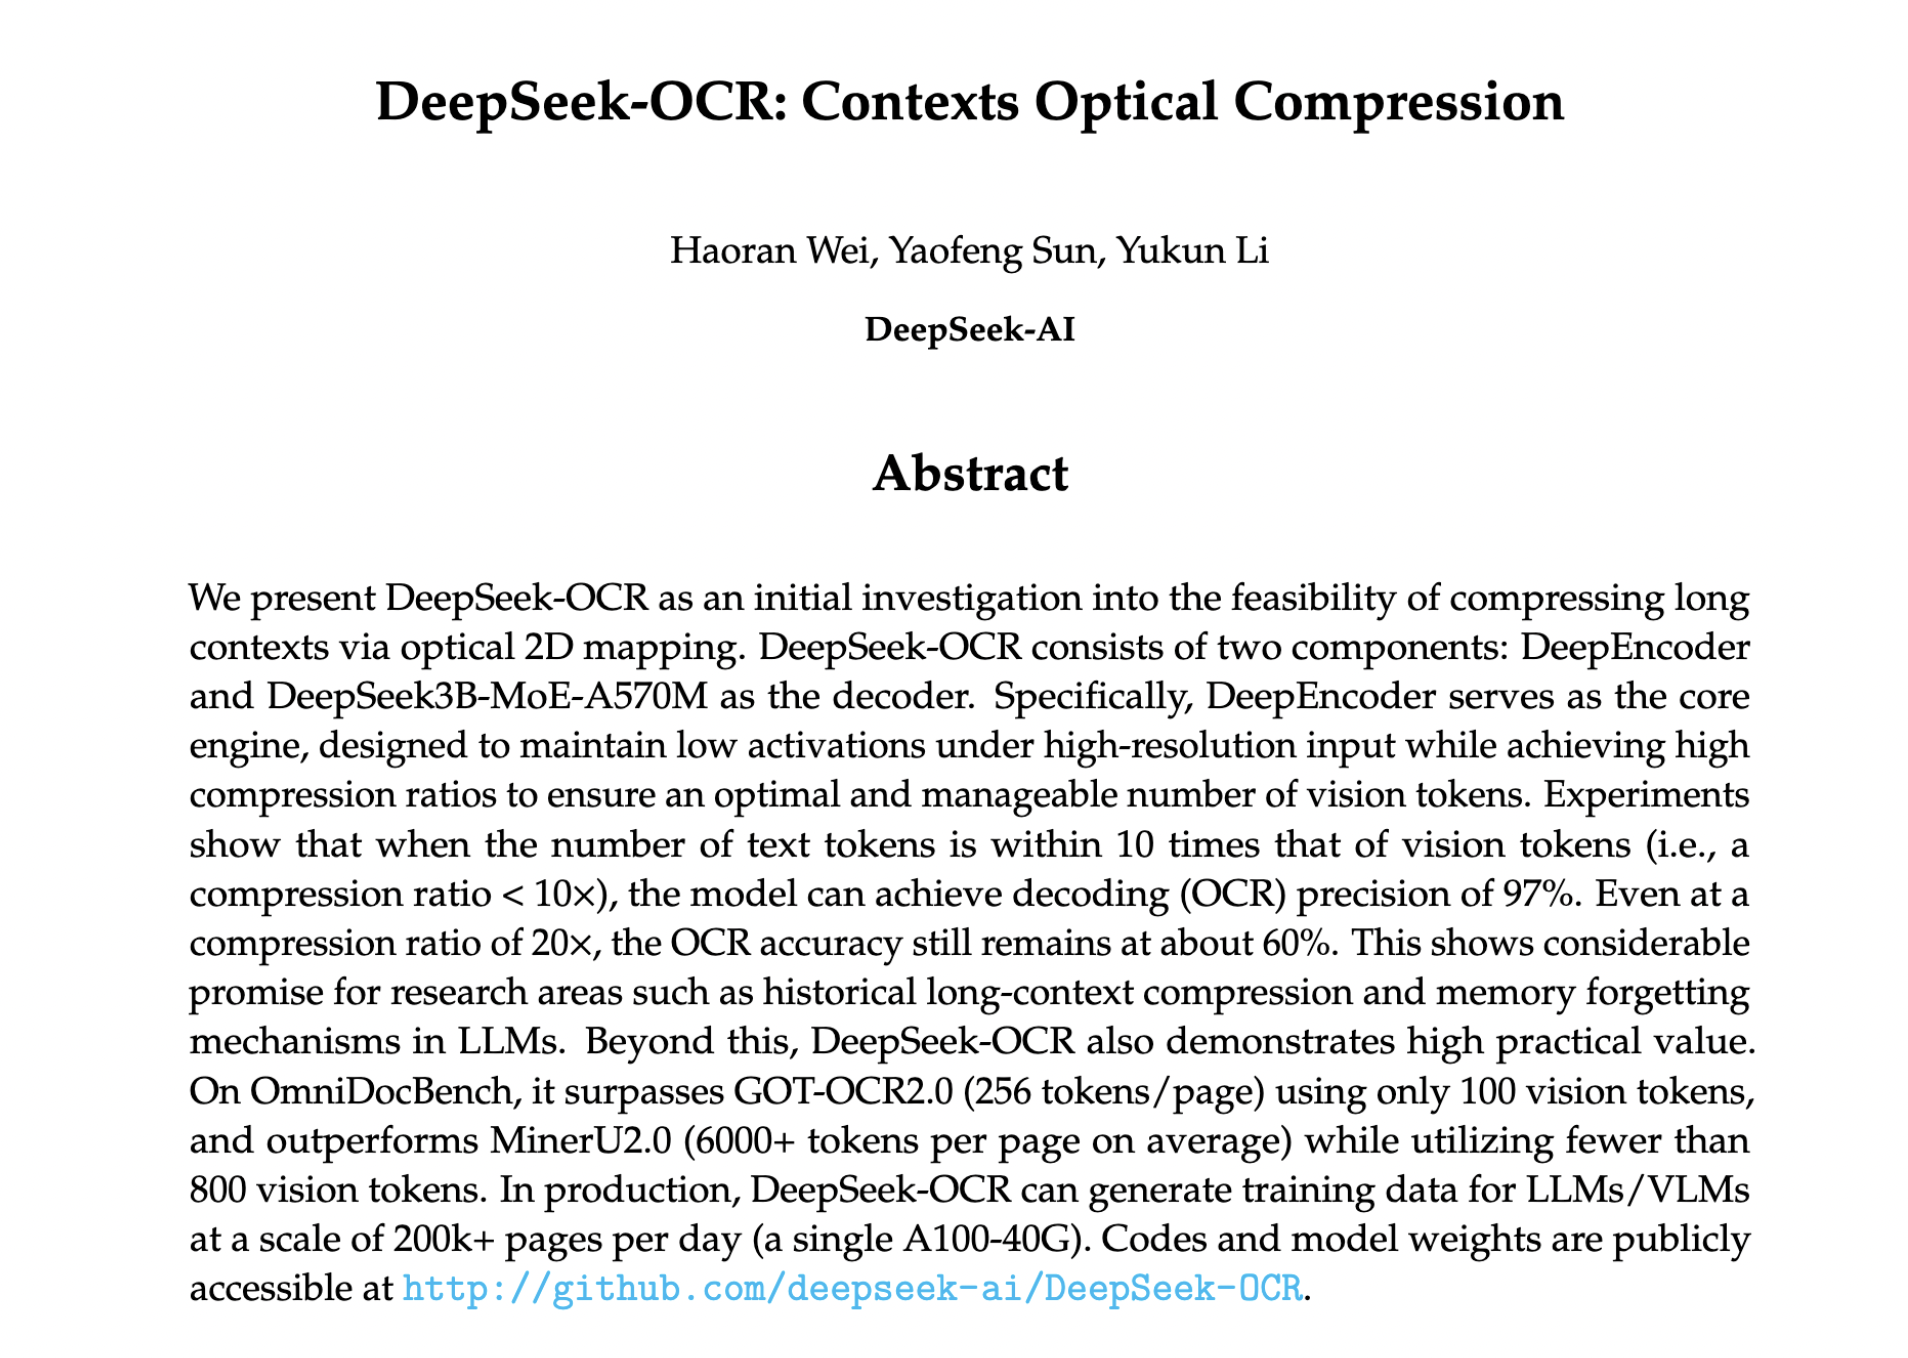

Image: (1908, 1358) (Compresses to ~256 vision tokens)


In [ ]:
from PIL import Image
from IPython.display import display

image_path = "sample_image.png"  # Upload
image = Image.open(image_path)

# URL alt
# import requests
# from io import BytesIO
# url = "https://example.com/doc.jpg"
# image = Image.open(BytesIO(requests.get(url).content))

display(image)
print(f"Image: {image.size} (Compresses to ~256 vision tokens)")

Run OCR with structured markdown output (preserves tables/headers). `image_size=640` enables Small mode (~100 vision tokens, 10x compression, 97% precision per paper Fig. 1a).

FlashAttn accelerates MoE decoder (~1s on A100).

In [8]:
prompt = "<image>\n<|grounding|>Convert the document to markdown."  # Official structured OCR

output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

res = model.infer(
    tokenizer=tokenizer,
    prompt=prompt,
    image_file=image_path,
    output_path=output_dir,
    base_size=1024,     # Base mode
    image_size=640,     # Small: 10x compression
    crop_mode=True,     # Layout/tables
    save_results=True,  # Annotated image
    test_compress=True  # Ratio log
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>title<|/ref|><|det|>[[193, 51, 820, 100]]<|/det|>
# DeepSeek-OCR: Contexts Optical Compression  

<|ref|>text<|/ref|><|det|>[[348, 165, 666, 200]]<|/det|>
Haoran Wei, Yaofeng Sun, Yukun Li  

<|ref|>text<|/ref|><|det|>[[450, 225, 564, 256]]<|/det|>
DeepSeek- AI  

<|ref|>sub_title<|/ref|><|det|>[[455, 326, 560, 366]]<|/det|>
## Abstract  

<|ref|>text<|/ref|><|det|>[[95, 419, 921, 966]]<|/det|>
We present DeepSeek- OCR as an initial investigation into the feasibility of compressing long contexts via optical 2D mapping. DeepSeek- OCR consists of two components: DeepEncoder and DeepSeek3B- MoE- A570M as the decoder. Specifically, DeepEncoder serves as the core engine, designed to maintain low activations under high- resolution input while achieving high compression ratios to ensure an optimal and manageable number of vision tokens. Experiments show that when the number of text tokens is within 10 times that of 

image: 0it [00:00, ?it/s]
other: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41692.88it/s]
